In [1]:
from pyspark import SparkContext, SparkConf, SparkFiles
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import pandas as pd
import csv

### <font color=blue size=4> mapper0 </font>

    這個mapper function是剛讀進資料時，將資料預先做處理。
    為了讓後面可以把centroid和data join在一起做計算，讓每一行資料都帶有相同的key (->("key", point))。


### <font color=blue size=4> mapperDistE </font>

    計算Euclidean distance。
    在把centroid和data join在一起之後，就可以方便的從同一行中取到各維度的點去計算。計算方法就是取各維度數值相減再平方，再全部相加起來，最後開根號。
    算完之後，再將資料以 $((data), ((centroid), dist))$的資料存起來，所以同一個點會有10行value為((centroid) , dist)的資料。


### <font color=blue size=4>mapperDistM </font>
    計算Manhattan distance。計算方法就是取各維度數值相減取絕對值，再全部相加起來。
    和mapperDistE一樣，也會把資料存成$((data), ((centroid), dist))$的形式。

In [2]:
def mapper0(line):
    tmp = line.split(" ")
    return "key", (tuple(tmp))


# calculate the Euclidean distance
def mapperDistE(line):
    tmp = 0
    for i in range(58):
        tmp += (float(line[1][0][i]) - float(line[1][1][i])) ** 2
    tmp = tmp ** 0.5
    return line[1][0], (line[1][1], tmp)   # (data, (centroid, dist))

# calculate the Manhattan distance
def mapperDistM(line):
    tmp = 0
    for i in range(58):
        tmp += abs(float(line[1][0][i]) - float(line[1][1][i]))
    return line[1][0], (line[1][1], tmp)  # (data, (centroid, dist))


### <font color=blue size=4> mapperMinE、mapperMinM </font>

    在做mapperMinE或mapperMinM之前，會先把從上一階段的mapper function所回傳的資料用groupByKey合在一起，這樣就會把同一點的所有(centroid, dist)放在同一行中。
    這兩個mapper function都是用來計算各點和不同centroid的距離，並找到有最短距離的centroid，以及計算每個點的cost，兩個function的內容只有計算cost的部分不同而已。因為在整筆data中，可能有很多重複的點，雖然點是相同的，但是對於計算cost或是新的centroid時的貢獻度不能合而為一，而他們的(centroid, dist) pair會全部合到同一行，所以藉由計算(centroid, dist) pair的個數，來檢查這個點有沒有重複，並記錄下來（duplicate），而計算出的cost也要乘上重複的個數。
    為了維持centroid的順序，也會將centroid的index存在資料中，以((idx, c), ((data, duplicate), duplicate*dist)) 的形式回傳。
    
    之後會再把回傳的cost加總在一起，算出這次iteration的cost。

In [3]:
# find the shortest distance and calculate parts of cost
def mapperMinE(line):
    minDist = 1.0e+100
    index = 0
    for i in range(10):
        if(line[1][i][1] < minDist):
            minDist = line[1][i][1]
            nearest = line[1][i][0]
            index = i
    cost = minDist ** 2
    duplicate = len(line[1]) / 10
    return (index, nearest), ((line[0], int(duplicate)), duplicate * cost)   
    # ((idx, c), ((data, duplicate), duplicate*dist))

def mapperMinM(line):
    minDist = 1.0e+100
    index = 0
    for i in range(10):
        if(line[1][i][1] < minDist):
            minDist = line[1][i][1]
            nearest = line[1][i][0]
            index = i
    duplicate = len(line[1]) / 10
    return (index, nearest), ((line[0], int(duplicate)), duplicate * minDist)   
    # ((idx, c), ((data, duplicate), duplicate*dist))


### <font color=blue size=4> mappercCen </font>

    在進到這個mapper function前，也會先將之前的資料用groupByKey合在一起，整理成key為centroid，value為所有被分到這個centroid的資料點(centroid, [((data, dup), dist), ((data, dup), dist), ...])的形式。
    接著就可以藉由那些資料點計算出新的centroid，算法就是把所有點的各維度數值相加起來，再除以點的個數。這裡也要注意，重複的點也要計算進去！
    算出新的centroid之後，再以和一開始相同的資料形式("key", point)回傳。
    
<br>       
這次我並沒有使用到reducer function，因為groupByKey能把資料合成我比較好處理的形式。

In [4]:
# calculate new centroid
def mapperCen(line):
    count = 0
    centroid = list(line[0][1])
    for i in range(len(centroid)):
        centroid[i] = 0
    for Data in line[1]:  # Data = (((data), dup), dist)
        amount = Data[0][1] # duplicate
        count += amount
        for idx in range(len(Data[0][0])):
            centroid[idx] += float(Data[0][0][idx]) * amount
                
    for i in range(len(centroid)):
        centroid[i] /= count
            
    return "key", tuple(centroid)


In [5]:
pathData = "hw3-q2-kmeans/data.txt"
pathC1 = "hw3-q2-kmeans/c1.txt"
pathC2 = "hw3-q2-kmeans/c2.txt"
fileData = sc.textFile(pathData)
fileC1 = sc.textFile(pathC1)
fileC2 = sc.textFile(pathC2)
costE_c1, costE_c2 = [], []


fileData = fileData.map(mapper0)
fileC1 = fileC1.map(mapper0)
fileC2 = fileC2.map(mapper0)
Centroid1 = fileC1
Centroid2 = fileC2

# Euclidean distance / c1
for i in range(20):
    Data = fileData.join(Centroid1)
    dist = Data.map(mapperDistE)
    dist = dist.groupByKey().mapValues(list)  # (data, [(c, dist), (c, dist), ...])
    minDist = dist.map(mapperMinE)

    costE_c1.append(minDist.values().values().sum())
    
    minDist = minDist.groupByKey().mapValues(list).sortByKey() # ((idx, c), [((data, dup), dist), ((data, dup), dist), ...])
    newCentroid = minDist.map(mapperCen)
    Centroid1 = newCentroid
    
print("cost of Euclidean distance with c1: ")
print(costE_c1)
print()
    
# Euclidean distance / c2
for i in range(20):
    Data = fileData.join(Centroid2)
    dist = Data.map(mapperDistE)
    dist = dist.groupByKey().mapValues(list)  # (data, [(c, dist), (c, dist), ...])
    minDist = dist.map(mapperMinE)

    costE_c2.append(minDist.values().values().sum())

    minDist = minDist.groupByKey().mapValues(list).sortByKey() # (c, [((data, dup), dist), ((data, dup), dist), ...])
    newCentroid = minDist.map(mapperCen)
    Centroid2 = newCentroid

print("cost of Euclidean distance with c2: ")
print(costE_c2)

CentroidE1 = Centroid1
CentroidE2 = Centroid2


cost of Euclidean distance with c1: 
[623660345.306411, 509862908.29754555, 485480681.8720076, 463997011.6850125, 460969266.57299626, 460537847.9827678, 460313099.6535454, 460003523.8894073, 459570539.317735, 459021103.3422911, 458490656.1919806, 457944232.5879744, 457558005.1986767, 457290136.3523019, 457050555.0595627, 456892235.61535466, 456703630.73703384, 456404203.0189748, 456177800.5419932, 455986871.0273458]

cost of Euclidean distance with c2: 
[438747790.02791697, 249803933.6260032, 194494814.4063125, 169804841.45154303, 156295748.80627608, 149094208.10896617, 142508531.61961526, 132303869.40652971, 117170969.83719075, 108547377.17857005, 102237203.31799597, 98278015.74975674, 95630226.12177396, 93793314.05119298, 92377131.96821073, 91541606.25423887, 91045573.83042462, 90752240.101408, 90470170.18122734, 90216416.17563123]


Improvement of c1 with Euclidean distance:  26.885383 %
Improvement of c2 with Euclidean distance:  79.437750 %

---------------------------------------------



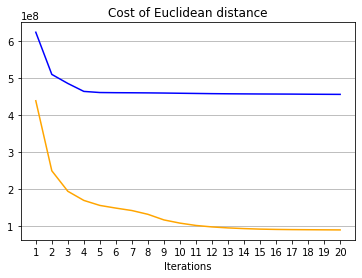

,c1,c2
0,6.236603e+08,4.387478e+08
1,5.098629e+08,2.498039e+08
2,4.854807e+08,1.944948e+08
3,4.639970e+08,1.698048e+08
4,4.609693e+08,1.562957e+08
5,4.605378e+08,1.490942e+08
6,4.603131e+08,1.425085e+08
7,4.600035e+08,1.323039e+08
8,4.595705e+08,1.171710e+08
9,4.590211e+08,1.085474e+08


In [6]:
improvementE1 = (abs(costE_c1[19] - costE_c1[0])) / costE_c1[0] * 100
improvementE2 = (abs(costE_c2[19] - costE_c2[0])) / costE_c2[0] * 100
print("Improvement of c1 with Euclidean distance: ", '%.6f'%improvementE1, "%")
print("Improvement of c2 with Euclidean distance: ", '%.6f'%improvementE2, "%")
print()
print("---------------------------------------------")
print()

iteration = range(1, 21)
plt.plot(iteration, costE_c1, "blue")
plt.plot(iteration, costE_c2, "orange")
plt.title('Cost of Euclidean distance')
plt.xlabel('Iterations')  
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.grid(axis='y')
plt.show()

dictE = {"c1": costE_c1, "c2": costE_c2}
pd.DataFrame(dictE)

In [7]:
costM_c1, costM_c2 = [], []
Centroid1 = fileC1
Centroid2 = fileC2

# Manhattan distance / c1
for i in range(20):
    Data = fileData.join(Centroid1)
    dist = Data.map(mapperDistM)
    dist = dist.groupByKey().mapValues(list)  # (data, [(c, dist), (c, dist), ...])
    minDist = dist.map(mapperMinM)

    costM_c1.append(minDist.values().values().sum())

    minDist = minDist.groupByKey().mapValues(list).sortByKey() # (c, [((data, dup), dist), ((data, dup), dist), ...])
    newCentroid = minDist.map(mapperCen)
    Centroid1 = newCentroid
    
print("cost of Manhattan distance with c1: ")
print(costM_c1)
print()

# Manhattan distance / c2
for i in range(20):
    Data = fileData.join(Centroid2)
    dist = Data.map(mapperDistM)
    dist = dist.groupByKey().mapValues(list)  # (data, [(c, dist), (c, dist), ...])
    minDist = dist.map(mapperMinM)

    costM_c2.append(minDist.values().values().sum())

    minDist = minDist.groupByKey().mapValues(list).sortByKey() # (c, [((data, dup), dist), ((data, dup), dist), ...])
    newCentroid = minDist.map(mapperCen)
    Centroid2 = newCentroid
    
print("cost of Manhattan distance with c2: ")
print(costM_c2)
    
CentroidM1 = Centroid1
CentroidM2 = Centroid2

cost of Manhattan distance with c1: 
[550117.142, 464869.27587929735, 470897.3822772978, 483914.4091733448, 489216.071003429, 487629.6685499798, 483711.9232137456, 475330.77349323133, 474871.23884636106, 457232.9201150776, 447494.38619735045, 450915.0125766772, 451250.3670725654, 451974.5955397494, 451570.36406995665, 452739.0113664559, 453082.7302871836, 450583.6708602985, 450368.74931674165, 449011.3637255191]

cost of Manhattan distance with c2: 
[1433739.3099999996, 1084488.7769648791, 973431.7146620421, 895934.5925630709, 865128.3352940821, 845846.6470313492, 827219.5827561263, 803590.3456011105, 756039.5172761205, 717332.9025432304, 694587.9252526884, 684444.5019967911, 674574.7475478557, 667409.4699160267, 663556.6278215036, 660162.7772287574, 656041.3222947128, 653036.7540731605, 651112.4262522729, 649689.0131843531]


Improvement of c1 with Manhattan distance:  18.378954 %
Improvement of c2 with Manhattan distance:  54.685694 %

---------------------------------------------



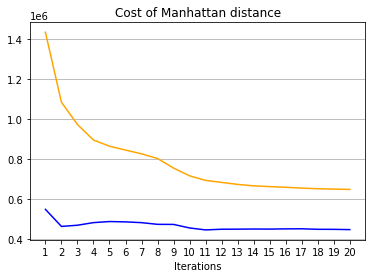

,c1,c2
0,550117.142000,1.433739e+06
1,464869.275879,1.084489e+06
2,470897.382277,9.734317e+05
3,483914.409173,8.959346e+05
4,489216.071003,8.651283e+05
5,487629.668550,8.458466e+05
6,483711.923214,8.272196e+05
7,475330.773493,8.035903e+05
8,474871.238846,7.560395e+05
9,457232.920115,7.173329e+05


In [8]:
improvementM1 = (abs(costM_c1[19] - costM_c1[0])) / costM_c1[0] * 100
improvementM2 = (abs(costM_c2[19] - costM_c2[0])) / costM_c2[0] * 100
print("Improvement of c1 with Manhattan distance: ", '%.6f'%improvementM1,  "%")
print("Improvement of c2 with Manhattan distance: ", '%.6f'%improvementM2,  "%")
print()
print("---------------------------------------------")
print()
dictM = {"c1": costM_c1, "c2": costM_c2}

iteration = range(1, 21)
plt.plot(iteration, costM_c1, "blue")
plt.plot(iteration, costM_c2, "orange")
plt.title('Cost of Manhattan distance')
plt.xlabel('Iterations')  
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.grid(axis='y')
plt.show()

pd.DataFrame(dictM)

In [9]:
# Calculate the distances of pairs of Centroids / AFTER Euclidean / c1
cen = CentroidE1.collect()
disByE, disByM = [], []

# Euclidean distance
with open('Euclidean distances for all pairs of c1_E.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByE.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByE.append('')
            else:
                for k in range(58):
                    tmp += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp = pow(tmp, 0.5)
                disByE.append('%.6f'%tmp)
        writer.writerow(disByE)
        disByE = []

# Manhattan distance
with open('Manhattan distances for all pairs of c1_E.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByM.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByM.append('')
            else:
                for k in range(58):
                    tmp += abs(cen[i][1][k]-cen[j][1][k])
                disByM.append('%.6f'%tmp)
        writer.writerow(disByM)
        disByM = []

In [10]:
# Calculate the distances of pairs of Centroids / AFTER Euclidean / c2
cen = CentroidE2.collect()
disByE, disByM = [], []

# Euclidean distance
with open('Euclidean distances for all pairs of c2_E.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByE.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByE.append('')
            else:
                for k in range(58):
                    tmp += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp = pow(tmp, 0.5)
                disByE.append('%.6f'%tmp)
        writer.writerow(disByE)
        disByE = []

# Manhattan distance
with open('Manhattan distances for all pairs of c2_E.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByM.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByM.append('')
            else:
                for k in range(58):
                    tmp += abs(cen[i][1][k]-cen[j][1][k])
                disByM.append('%.6f'%tmp)
        writer.writerow(disByM)
        disByM = []

In [11]:
# Calculate the distances of pairs of Centroids / AFTER Manhattan / c1
cen = CentroidM1.collect()
disByE, disByM = [], []

# Euclidean distance
with open('Euclidean distances for all pairs of c1_M.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByE.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByE.append('')
            else:
                for k in range(58):
                    tmp += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp = pow(tmp, 0.5)
                disByE.append('%.6f'%tmp)
        writer.writerow(disByE)
        disByE = []

# Manhattan distance
with open('Manhattan distances for all pairs of c1_M.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByM.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByM.append('')
            else:
                for k in range(58):
                    tmp += abs(cen[i][1][k]-cen[j][1][k])
                disByM.append('%.6f'%tmp)
        writer.writerow(disByM)
        disByM = []

In [12]:
# Calculate the distances of pairs of Centroids / AFTER Manhattan / c2
cen = CentroidM2.collect()
disByE, disByM = [], []

# Euclidean distance
with open('Euclidean distances for all pairs of c2_M.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Euclidean', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByE.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByE.append('')
            else:
                for k in range(58):
                    tmp += pow((cen[i][1][k]-cen[j][1][k]), 2)
                tmp = pow(tmp, 0.5)
                disByE.append('%.6f'%tmp)
        writer.writerow(disByE)
        disByE = []

# Manhattan distance
with open('Manhattan distances for all pairs of c2_M.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['Manhattan', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i in range(10):
        disByM.append(i+1)
        for j in range(10):
            tmp = 0
            if j < i :
                disByM.append('')
            else:
                for k in range(58):
                    tmp += abs(cen[i][1][k]-cen[j][1][k])
                disByM.append('%.6f'%tmp)
        writer.writerow(disByM)
        disByM = []